### Required Modules

In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import pickle
import matplotlib.pyplot as plt

### Load Data 

In [3]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data.pkl")

X_train, Y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/validation_data.pkl")

X_val, Y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [4]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

###  Best Neural Network Classifier From Initial Grid Search

**Initial Grid Search Parameters**

Number of nodes: [5,10, 20, 30]

Number of layers: [2,3,4]

In [ ]:
file_path = '/share/rcifdata/jbarr/UKAEAGroupProject/grid_search/'
trainings = []
for i in range(336):
    trial_dict = pickle.load(open(file_path+"trial_"+str(i)+".pkl", 'rb'))
    trainings.append(trial_dict)

In [ ]:
### calculate the number of parameters
def model_params(nodes, n_inputs=15):
    nodes.append(1)
    params = 0
    
    # bottle neck, 0 if model doesn't include a bottle neck and 1 if the model does include one.
    bottle_in = 0
    bottle_hidden = 0
    
    # parameters from models
    for i in range(len(nodes)):
        if i == 0:
            if nodes[i] < n_inputs: bottle_in = 1
            params += n_inputs * nodes[i]
        else:
            params += nodes[i-1]* nodes[i]
            
            if nodes[i-1] < nodes[i]: bottle_hidden = 1
    
    # parameters from biases
    for i in nodes: 
        params += i
    return params, bottle_in, bottle_hidden

In [ ]:
assert model_params([2,2])[0] == 41

In [ ]:
# Find the best architecture
best_trial = None 
best_val_acc = - sys.float_info.max
val_accs = []
n_params = []
bottle_in = []
bottle_hid = []

for trial in trainings:
    val_acc = trial["perfomance"][1]
    
    val_accs.append(val_acc)
    
    n_param, bot_in, bot_hid  = model_params(list(trial['nodes']))
    
    n_params.append(n_param)
    
    bottle_in.append(bot_in)
    bottle_hid.append(bot_hid)
    
    
    
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        best_trial = trial
        
n_params = np.array(n_params)
bottle_in = np.array(bottle_in)
bottle_hid= np.array(bottle_hid)
val_accs = np.array(val_accs)


In [ ]:
print("Best Model\n")
print("Network:",best_trial["nodes"],"\n" )
print("Validation accuracy:", best_trial['perfomance'][1])

In [ ]:
plt.figure()
plt.plot(best_trial["history"]["acc"],color = 'blue')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
plt.figure()
plt.plot(best_trial["history"]["loss"], color = 'blue')
plt.title("Trainign Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [ ]:
plt.figure()
plt.hist(val_accs, bins = 20, color = 'purple');
plt.xlabel("Validation Accuracy")
plt.ylabel("Frequency")

In [ ]:
plt.figure()
plt.plot(n_params[np.where(bottle_in == 0)], val_accs[np.where(bottle_in == 0)], '.', label = 'Normal')
plt.plot(n_params[np.where(bottle_in == 1)], val_accs[np.where(bottle_in == 1)], '.', label = 'Input bn')
plt.plot(n_params[np.where(bottle_hid == 1)], val_accs[np.where(bottle_hid == 1)], '.', label = 'Hidden bn')
plt.xlabel("Number of Model Parameters")
plt.ylabel("Validation Accuracy")
plt.legend()

### Grid Search Conclusion

Looking at the plot above we can see that increasing the number of model parameters in general leads to an increase in the models validation accuracy, the graph looks as though it will plateau, but it also suggestes we haven't hit the peak, a further grid search of models with a higher number of parameters should be conducted.

### Final classifier

In [6]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [ ]:
model = nn_classifier()

In [ ]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = 'acc')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [ ]:
history = model.fit(x_train, Y_train, validation_data = (x_val, Y_val), batch_size = 4096, epochs =50, callbacks=[stop_early])

In [ ]:
!mkdir -p saved_model
model.save('saved_model/classifier_model')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
plt.plot(history.history['acc'], 'o', label = 'Train acc')
plt.plot(history.history['val_acc'], 'o', label = 'Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
plt.figure()
plt.plot(history.history['loss'], 'o', label = 'Train loss')
plt.plot(history.history['val_loss'], 'o', label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate Model on Test Set

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data.pkl")

X_test, Y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [ ]:
x_test = scaler.transform(X_test)

In [ ]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, predictions)

In [ ]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [ ]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

In [ ]:
n_positive = np.where(Y_test ==0)[0].shape[0]
n_negative = np.where(Y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

In [ ]:
con_mat = confusion_matrix(Y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Distributions from classifier

In [ ]:
preds = np.round(predictions).flatten()

In [ ]:
no_output = x_test[np.where(preds == 0)]
yes_output = x_test[np.where(preds == 1)] 
assert no_output.shape[0] + yes_output.shape[0] == x_test.shape[0]

In [ ]:
columns = list(train_data.iloc[:,:-1].columns)
print(columns)

In [ ]:
for i, column in enumerate(columns):
    # find the mean and std 
    mean_no, mean_yes = np.mean(no_output[:,i]), np.mean(yes_output[:,i])
    std_no, std_yes = np.std(no_output[:,i]), np.std(yes_output[:,i])
    
    no_lower, no_upper = (mean_no - 3*std_no), (mean_no + 3*std_no)
    yes_lower, yes_upper = (mean_yes - 3*std_yes), (mean_yes + 3*std_yes)
    
    plt.figure()
    plt.hist(no_output[:,i], histtype = 'step', color = 'lime',
             label =" No output", density = True, bins =50, range = (no_lower, no_upper));
    
    plt.hist(yes_output[:,i], histtype = 'step', color = 'purple',
             label = "Output", density = True, bins = 50, range = (yes_lower,yes_upper ));
    plt.legend()
    plt.xlabel(column)

# Train model with varying number of data points

In [15]:
def nn_classifier_big():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [6]:
val_indices = np.random.choice(x_val.shape[0], size = 100_000, replace=False)
x_val_sample = x_val[val_indices]
y_val_sample = Y_val[val_indices]

In [16]:
training_size = [100, 500, 1000, 2000, 5000,
                 7500, 10_000, 12_500, 15_000, 20_000, 30_000, 50_000,
                 100_000, 200_000, 500_000,
                 1_000_000, x_train.shape[0]]
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

permuted_idx = np.random.permutation(x_train.shape[0])
permuted_x = x_train[permuted_idx]
permuted_y = Y_train[permuted_idx]

for size in training_size:

    x_sample = permuted_x[:size]
    y_sample = permuted_y[:size]
    
    batch_size = size if size <= 10_000 else 4096
    
    print(f"Training model with {size} training points:")
    model = nn_classifier_big()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'acc')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)
    history = model.fit(x_sample,
                        y_sample,
                        validation_data = (x_val_sample, y_val_sample),
                        batch_size = batch_size,
                        epochs = 100,
                        callbacks = [stop_early])
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])
    
    print("\n \n")

Training model with 100 training points:
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6893 - acc: 0.5900 - val_loss: 0.6801 - val_acc: 0.6597
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.6723 - acc: 0.6300 - val_loss: 0.6745 - val_acc: 0.6615
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.6694 - acc: 0.6500 - val_loss: 0.6686 - val_acc: 0.6615
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6738 - acc: 0.6400 - val_loss: 0.6637 - val_acc: 0.6615
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.6721 - acc: 0.6400 - val_loss: 0.6589 - val_acc: 0.6615
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.6565 - acc: 0.6400 - val_loss: 0.6540 - val_acc: 0.6615
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.6511 - acc: 0.6400 - val_loss: 0.6493 - val_acc: 0.6615
Epoch 8/100
1/1 [==============================] - 1s 1s/step -

4/4 [==============================] - 0s 78ms/step - loss: 0.5669 - acc: 0.6829 - val_loss: 0.5622 - val_acc: 0.6822
Epoch 12/100
4/4 [==============================] - 0s 76ms/step - loss: 0.5643 - acc: 0.6806 - val_loss: 0.5622 - val_acc: 0.6829
Epoch 13/100
4/4 [==============================] - 0s 76ms/step - loss: 0.5667 - acc: 0.6813 - val_loss: 0.5585 - val_acc: 0.6849
Epoch 14/100
4/4 [==============================] - 0s 77ms/step - loss: 0.5645 - acc: 0.6848 - val_loss: 0.5569 - val_acc: 0.6862
Epoch 15/100
4/4 [==============================] - 0s 81ms/step - loss: 0.5619 - acc: 0.6860 - val_loss: 0.5551 - val_acc: 0.6859
Epoch 16/100
4/4 [==============================] - 0s 76ms/step - loss: 0.5572 - acc: 0.6876 - val_loss: 0.5565 - val_acc: 0.6863
Epoch 17/100
4/4 [==============================] - 0s 79ms/step - loss: 0.5561 - acc: 0.6926 - val_loss: 0.5522 - val_acc: 0.6879
Epoch 18/100
4/4 [==============================] - 0s 77ms/step - loss: 0.5524 - acc: 0.6943 - 

4/4 [==============================] - 0s 75ms/step - loss: 0.4966 - acc: 0.7401 - val_loss: 0.4995 - val_acc: 0.7406
Epoch 74/100
4/4 [==============================] - 0s 78ms/step - loss: 0.4957 - acc: 0.7449 - val_loss: 0.4998 - val_acc: 0.7411
Epoch 75/100
4/4 [==============================] - 0s 79ms/step - loss: 0.4960 - acc: 0.7395 - val_loss: 0.4976 - val_acc: 0.7408
Epoch 76/100
4/4 [==============================] - 0s 75ms/step - loss: 0.4973 - acc: 0.7377 - val_loss: 0.4965 - val_acc: 0.7402
Epoch 77/100
4/4 [==============================] - 0s 76ms/step - loss: 0.4927 - acc: 0.7425 - val_loss: 0.4980 - val_acc: 0.7390
Epoch 78/100
4/4 [==============================] - 0s 78ms/step - loss: 0.4898 - acc: 0.7458 - val_loss: 0.4966 - val_acc: 0.7387
Epoch 79/100
4/4 [==============================] - 0s 75ms/step - loss: 0.4939 - acc: 0.7398 - val_loss: 0.4966 - val_acc: 0.7405

 

Training model with 15000 training points:
Epoch 1/100
4/4 [==============================] 

4/4 [==============================] - 0s 87ms/step - loss: 0.4976 - acc: 0.7369 - val_loss: 0.4953 - val_acc: 0.7380
Epoch 57/100
4/4 [==============================] - 0s 82ms/step - loss: 0.5011 - acc: 0.7353 - val_loss: 0.4947 - val_acc: 0.7381
Epoch 58/100
4/4 [==============================] - 0s 81ms/step - loss: 0.4979 - acc: 0.7320 - val_loss: 0.4941 - val_acc: 0.7391
Epoch 59/100
4/4 [==============================] - 0s 81ms/step - loss: 0.4885 - acc: 0.7456 - val_loss: 0.4927 - val_acc: 0.7410
Epoch 60/100
4/4 [==============================] - 0s 85ms/step - loss: 0.4972 - acc: 0.7344 - val_loss: 0.4919 - val_acc: 0.7409
Epoch 61/100
4/4 [==============================] - 0s 81ms/step - loss: 0.4881 - acc: 0.7454 - val_loss: 0.4912 - val_acc: 0.7420
Epoch 62/100
4/4 [==============================] - 0s 85ms/step - loss: 0.4884 - acc: 0.7403 - val_loss: 0.4898 - val_acc: 0.7433
Epoch 63/100
4/4 [==============================] - 0s 87ms/step - loss: 0.4873 - acc: 0.7438 - 

5/5 [==============================] - 0s 77ms/step - loss: 0.5451 - acc: 0.7019 - val_loss: 0.5370 - val_acc: 0.7071
Epoch 19/100
5/5 [==============================] - 0s 74ms/step - loss: 0.5412 - acc: 0.7044 - val_loss: 0.5352 - val_acc: 0.7084
Epoch 20/100
5/5 [==============================] - 0s 74ms/step - loss: 0.5403 - acc: 0.7062 - val_loss: 0.5329 - val_acc: 0.7100
Epoch 21/100
5/5 [==============================] - 0s 77ms/step - loss: 0.5354 - acc: 0.7071 - val_loss: 0.5312 - val_acc: 0.7111
Epoch 22/100
5/5 [==============================] - 0s 74ms/step - loss: 0.5378 - acc: 0.7098 - val_loss: 0.5292 - val_acc: 0.7127
Epoch 23/100
5/5 [==============================] - 0s 73ms/step - loss: 0.5361 - acc: 0.7074 - val_loss: 0.5279 - val_acc: 0.7142
Epoch 24/100
5/5 [==============================] - 0s 78ms/step - loss: 0.5309 - acc: 0.7130 - val_loss: 0.5257 - val_acc: 0.7158
Epoch 25/100
5/5 [==============================] - 0s 73ms/step - loss: 0.5325 - acc: 0.7117 - 

5/5 [==============================] - 0s 72ms/step - loss: 0.4561 - acc: 0.7628 - val_loss: 0.4614 - val_acc: 0.7623
Epoch 81/100
5/5 [==============================] - 0s 73ms/step - loss: 0.4559 - acc: 0.7652 - val_loss: 0.4621 - val_acc: 0.7621
Epoch 82/100
5/5 [==============================] - 0s 72ms/step - loss: 0.4535 - acc: 0.7658 - val_loss: 0.4623 - val_acc: 0.7624
Epoch 83/100
5/5 [==============================] - 0s 72ms/step - loss: 0.4562 - acc: 0.7612 - val_loss: 0.4607 - val_acc: 0.7625
Epoch 84/100
5/5 [==============================] - 0s 75ms/step - loss: 0.4483 - acc: 0.7695 - val_loss: 0.4603 - val_acc: 0.7633
Epoch 85/100
5/5 [==============================] - 0s 72ms/step - loss: 0.4480 - acc: 0.7698 - val_loss: 0.4585 - val_acc: 0.7644
Epoch 86/100
5/5 [==============================] - 0s 71ms/step - loss: 0.4518 - acc: 0.7619 - val_loss: 0.4573 - val_acc: 0.7643
Epoch 87/100
5/5 [==============================] - 0s 73ms/step - loss: 0.4485 - acc: 0.7693 - 

8/8 [==============================] - 0s 56ms/step - loss: 0.4818 - acc: 0.7471 - val_loss: 0.4651 - val_acc: 0.7587
Epoch 43/100
8/8 [==============================] - 0s 52ms/step - loss: 0.4744 - acc: 0.7502 - val_loss: 0.4628 - val_acc: 0.7594
Epoch 44/100
8/8 [==============================] - 0s 55ms/step - loss: 0.4749 - acc: 0.7504 - val_loss: 0.4615 - val_acc: 0.7616
Epoch 45/100
8/8 [==============================] - 0s 53ms/step - loss: 0.4725 - acc: 0.7556 - val_loss: 0.4606 - val_acc: 0.7612
Epoch 46/100
8/8 [==============================] - 0s 54ms/step - loss: 0.4712 - acc: 0.7568 - val_loss: 0.4596 - val_acc: 0.7620
Epoch 47/100
8/8 [==============================] - 0s 55ms/step - loss: 0.4667 - acc: 0.7587 - val_loss: 0.4582 - val_acc: 0.7637
Epoch 48/100
8/8 [==============================] - 0s 53ms/step - loss: 0.4667 - acc: 0.7561 - val_loss: 0.4591 - val_acc: 0.7614
Epoch 49/100
8/8 [==============================] - 0s 55ms/step - loss: 0.4647 - acc: 0.7580 - 

13/13 [==============================] - 1s 47ms/step - loss: 0.5725 - acc: 0.6709 - val_loss: 0.5568 - val_acc: 0.6822
Epoch 5/100
13/13 [==============================] - 1s 45ms/step - loss: 0.5659 - acc: 0.6771 - val_loss: 0.5495 - val_acc: 0.6857
Epoch 6/100
13/13 [==============================] - 1s 46ms/step - loss: 0.5607 - acc: 0.6801 - val_loss: 0.5433 - val_acc: 0.6907
Epoch 7/100
13/13 [==============================] - 1s 46ms/step - loss: 0.5521 - acc: 0.6901 - val_loss: 0.5379 - val_acc: 0.6970
Epoch 8/100
13/13 [==============================] - 1s 47ms/step - loss: 0.5488 - acc: 0.6932 - val_loss: 0.5325 - val_acc: 0.7030
Epoch 9/100
13/13 [==============================] - 1s 46ms/step - loss: 0.5450 - acc: 0.6937 - val_loss: 0.5272 - val_acc: 0.7087
Epoch 10/100
13/13 [==============================] - 1s 45ms/step - loss: 0.5396 - acc: 0.7007 - val_loss: 0.5200 - val_acc: 0.7154
Epoch 11/100
13/13 [==============================] - 1s 47ms/step - loss: 0.5338 - acc

Epoch 66/100
13/13 [==============================] - 1s 45ms/step - loss: 0.4182 - acc: 0.7906 - val_loss: 0.4077 - val_acc: 0.7983
Epoch 67/100
13/13 [==============================] - 1s 45ms/step - loss: 0.4155 - acc: 0.7938 - val_loss: 0.4059 - val_acc: 0.7998
Epoch 68/100
13/13 [==============================] - 1s 44ms/step - loss: 0.4145 - acc: 0.7943 - val_loss: 0.4055 - val_acc: 0.8008
Epoch 69/100
13/13 [==============================] - 1s 45ms/step - loss: 0.4148 - acc: 0.7920 - val_loss: 0.4037 - val_acc: 0.8017
Epoch 70/100
13/13 [==============================] - 1s 45ms/step - loss: 0.4154 - acc: 0.7911 - val_loss: 0.4042 - val_acc: 0.8007
Epoch 71/100
13/13 [==============================] - 1s 44ms/step - loss: 0.4118 - acc: 0.7949 - val_loss: 0.4025 - val_acc: 0.8026
Epoch 72/100
13/13 [==============================] - 1s 45ms/step - loss: 0.4129 - acc: 0.7938 - val_loss: 0.3999 - val_acc: 0.8041
Epoch 73/100
13/13 [==============================] - 1s 44ms/step - 

25/25 [==============================] - 1s 40ms/step - loss: 0.4451 - acc: 0.7694 - val_loss: 0.4282 - val_acc: 0.7827
Epoch 28/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4426 - acc: 0.7727 - val_loss: 0.4229 - val_acc: 0.7870
Epoch 29/100
25/25 [==============================] - 1s 40ms/step - loss: 0.4390 - acc: 0.7759 - val_loss: 0.4203 - val_acc: 0.7905
Epoch 30/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4357 - acc: 0.7794 - val_loss: 0.4161 - val_acc: 0.7926
Epoch 31/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4333 - acc: 0.7788 - val_loss: 0.4142 - val_acc: 0.7947
Epoch 32/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4276 - acc: 0.7846 - val_loss: 0.4100 - val_acc: 0.7969
Epoch 33/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4279 - acc: 0.7833 - val_loss: 0.4069 - val_acc: 0.8001
Epoch 34/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4230 

49/49 [==============================] - 2s 37ms/step - loss: 0.4642 - acc: 0.7575 - val_loss: 0.4436 - val_acc: 0.7707
Epoch 11/100
49/49 [==============================] - 2s 37ms/step - loss: 0.4553 - acc: 0.7634 - val_loss: 0.4352 - val_acc: 0.7784
Epoch 12/100
49/49 [==============================] - 2s 37ms/step - loss: 0.4508 - acc: 0.7665 - val_loss: 0.4287 - val_acc: 0.7833
Epoch 13/100
49/49 [==============================] - 2s 37ms/step - loss: 0.4437 - acc: 0.7703 - val_loss: 0.4217 - val_acc: 0.7881
Epoch 14/100
49/49 [==============================] - 2s 38ms/step - loss: 0.4375 - acc: 0.7762 - val_loss: 0.4154 - val_acc: 0.7945
Epoch 15/100
49/49 [==============================] - 2s 38ms/step - loss: 0.4329 - acc: 0.7813 - val_loss: 0.4083 - val_acc: 0.7981
Epoch 16/100
49/49 [==============================] - 2s 37ms/step - loss: 0.4235 - acc: 0.7872 - val_loss: 0.4023 - val_acc: 0.8031
Epoch 17/100
49/49 [==============================] - 2s 37ms/step - loss: 0.4192 

123/123 [==============================] - 4s 35ms/step - loss: 0.4712 - acc: 0.7535 - val_loss: 0.4436 - val_acc: 0.7713
Epoch 5/100
123/123 [==============================] - 4s 35ms/step - loss: 0.4563 - acc: 0.7622 - val_loss: 0.4287 - val_acc: 0.7828
Epoch 6/100
123/123 [==============================] - 4s 35ms/step - loss: 0.4401 - acc: 0.7736 - val_loss: 0.4121 - val_acc: 0.7959
Epoch 7/100
123/123 [==============================] - 4s 35ms/step - loss: 0.4274 - acc: 0.7836 - val_loss: 0.3975 - val_acc: 0.8055
Epoch 8/100
123/123 [==============================] - 4s 35ms/step - loss: 0.4160 - acc: 0.7917 - val_loss: 0.3899 - val_acc: 0.8098
Epoch 9/100
123/123 [==============================] - 4s 36ms/step - loss: 0.4073 - acc: 0.7969 - val_loss: 0.3815 - val_acc: 0.8147
Epoch 10/100
123/123 [==============================] - 5s 37ms/step - loss: 0.4000 - acc: 0.8024 - val_loss: 0.3765 - val_acc: 0.8182
Epoch 11/100
123/123 [==============================] - 4s 36ms/step - lo

245/245 [==============================] - 9s 36ms/step - loss: 0.3603 - acc: 0.8258 - val_loss: 0.3435 - val_acc: 0.8359
Epoch 22/100
245/245 [==============================] - 9s 35ms/step - loss: 0.3591 - acc: 0.8265 - val_loss: 0.3450 - val_acc: 0.8339
Epoch 23/100
245/245 [==============================] - 9s 37ms/step - loss: 0.3595 - acc: 0.8264 - val_loss: 0.3441 - val_acc: 0.8349
Epoch 24/100
245/245 [==============================] - 9s 36ms/step - loss: 0.3585 - acc: 0.8265 - val_loss: 0.3429 - val_acc: 0.8351
Epoch 25/100
245/245 [==============================] - 9s 37ms/step - loss: 0.3590 - acc: 0.8263 - val_loss: 0.3425 - val_acc: 0.8357
Epoch 26/100
245/245 [==============================] - 10s 39ms/step - loss: 0.3577 - acc: 0.8266 - val_loss: 0.3422 - val_acc: 0.8361
Epoch 27/100
245/245 [==============================] - 9s 38ms/step - loss: 0.3576 - acc: 0.8270 - val_loss: 0.3414 - val_acc: 0.8361
Epoch 28/100
245/245 [==============================] - 9s 37ms/ste

816/816 [==============================] - 28s 35ms/step - loss: 0.3472 - acc: 0.8327 - val_loss: 0.3316 - val_acc: 0.8411
Epoch 29/100
816/816 [==============================] - 29s 35ms/step - loss: 0.3471 - acc: 0.8327 - val_loss: 0.3315 - val_acc: 0.8405
Epoch 30/100
816/816 [==============================] - 28s 35ms/step - loss: 0.3468 - acc: 0.8332 - val_loss: 0.3308 - val_acc: 0.8410
Epoch 31/100
816/816 [==============================] - 29s 36ms/step - loss: 0.3469 - acc: 0.8328 - val_loss: 0.3304 - val_acc: 0.8407
Epoch 32/100
816/816 [==============================] - 31s 38ms/step - loss: 0.3471 - acc: 0.8329 - val_loss: 0.3308 - val_acc: 0.8413

 



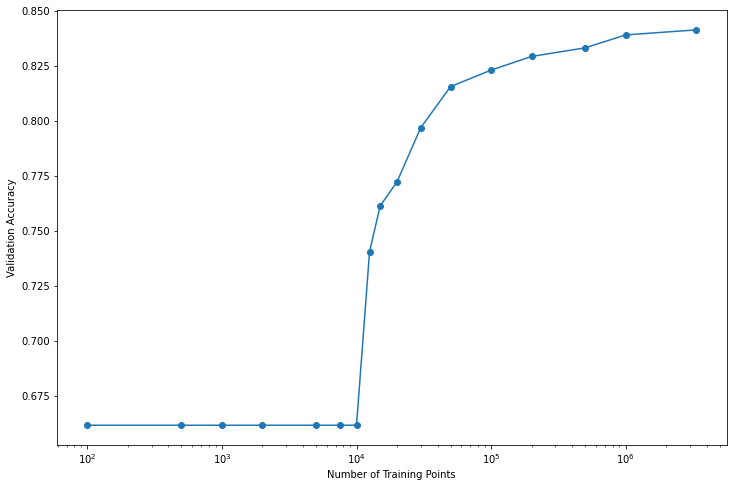

In [17]:
loss_ = [x[-1] for x in val_losses]
acc_ = [x[-1] for x in val_accuracies]


plt.figure(figsize = (12,8))

plt.plot(training_size, acc_, "-o")
plt.xscale("log")
plt.xlabel("Number of Training Points");
plt.ylabel("Validation Accuracy");